# Spectroscopy of a three 2D cavity - two qubit system, with thermal losses: <mark>Solving the Master Equation</mark>

1. **Introduction**
2. **Problem parameters**
3. **Setting up operators and Hamiltonian's**
4. **Frequency spectrum of the coupled system**
5. **Evolving qubit 1 in the system with time**

<u>Author</u> : Soumya Shreeram (shreeramsoumya@gmail.com)<br>
<u>Supervisor</u> : Yu-Chin Chao (ychao@fnal.gov) <br>
<u>Date</u>$\ \ \ \$: 7th July 2019<br>

This script was coded as part of the Helen Edwards Summer Internship program at Fermilab.

## 1. Introduction

A multi-mode QED architecture is explored as described in by [McKay et *al*](http://schusterlab.uchicago.edu/static/pdfs/McKay2015.pdf). The hamiltonian for such a system with two qubits with frequencies $v_{Q,1}$, $v_{Q,2}$, and $n$ mode filter can be described as the sum of the qubit Hamiltonian, $\hat{H}_Q$, the filter Hamiltonian, $\hat{H}_F$, and the qubit-filter coupling Hamiltonian, $\hat{H}_{Q-F},$
$$ \hat{H} = \hat{H_Q} + \hat{H_F} + \hat{H}_{Q-F} $$

$$ \hat{H_Q} = h\ v_{Q,1}\ \frac{\hat{ \sigma}^z_1}{2} + h\ v_{Q,2}\ \frac{\hat{ \sigma}^z_2}{2}$$

$$ \hat{H}_{F} = \sum_{i=1}^{n}h\ v_{F}\ \hat{a}^{\dagger}_i \hat{a}_i +  \sum_{i=2}^{n}h\ g_{F}\ (\hat{a}^{\dagger}_i \hat{a}_{i-1} + \hat{a}^{\dagger}_{i-1} \hat{a}_i)$$

$$ \hat{H}_{Q-F} = h\ g_{Q1,F}\ (\hat{a}^{\dagger}_1 \hat{\sigma}^-_1 + \hat{a}_1 \hat{\sigma}^+_1) + h\ g_{Q2,F}\ (\hat{a}^{\dagger}_n \hat{\sigma}^-_2 + \hat{a}_n \hat{\sigma}^+_2)$$

where $\hat{\sigma}^{+(-)}$ is the raising and lowering operator for the qubit, $\hat{a}_i$ creates a photon in the $i^{th}$ resonantor, $g_F$ is the filter-filter coupling, and $g_{Q,F}$ is the qubit-filter coupling.

Here we must also account for the interaction of the quantum state with it's environment. This can be represented by a non-Hermitian term in the Hamiltonian such that,
$$\displaystyle H_{\rm eff}(t) = H(t) - \frac{i\hbar}{2}\sum_n c_n^\dagger c_n$$
where $c_n$ is the collapse operator

The code calculates the eigen modes for such a system when the qubit 1 frequency is changed. 

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import numpy as np
from math import pi
from qutip import *

## 2. Problem parameters
Here we use $\hbar=1$; the coupling terms are redefined with a multiple of $2\pi$ before them for convinience.

In [24]:
w_q1 = 2*pi*6.85;    # Qubit 1 frequency
w_q2 = 2*pi*6.82;    # Qubit 2 frequency: generally in the range from 1-9 GHz
w_f1 = 2*pi*7.1      # Resonator/ Filter frequency
w_f2 = 2*pi*7.24
w_f3 = 2*pi*7.37
g_f1 = 2*pi*11.8    # Filter-filter coupling
g_f2 = 2*pi*19.8 
g_q1f = 2*pi*13.5   # qubit-fitler coupling
g_q2f = 2*pi*14.4
numF = 3             # number of filters
N = 2                # number of fock states

kappa = 1.0/0.129   # cavity dissipation rate
n_th_a = 0.063      # avg. no. of thermal bath excitation

times = np.linspace(0,0.6,100)

## 3. Setting up operators and the Hamiltonian's

For every qubit: <br> <br>
**sm** $\ \rightarrow \ \hat{\sigma}^{+(-)}$ is the raising and lowering operator of the *qubit* <br>
**sz** $\ \ \rightarrow \ \sigma_z $ is the Pauli-z matrix of the *qubit* <br>
**n** $\ \ \ \rightarrow \ n$ is the number operator

In [25]:
def Hqubit(sz, w_q):
  """ 
  Comuptes the qubit hamiltonian
  @param sz :: Pauli's z matrix
  @param w_q :: qubit frequency
  """
  return 0.5*sz*w_q

def numOp(m):
  """
  Computes the number operator 
  @param loweringMat :: lowering matrix operator for a system
  """
  return m.dag()*m

def sumDagger(m):
  """
  Computes sum of operator m and m.dag()
  @param a1 :: destruction operator 1
  @param a2 :: destruction operator 2
  """
  return m+m.dag()

### 3.1 Qubit-cavity system operators and Hamiltonian's

In [26]:
# cavity 1, 2, 3 destruction operators
a1 = tensor(destroy(N), qeye(N), qeye(N), qeye(2), qeye(2))
a2 = tensor(qeye(N), destroy(N), qeye(N), qeye(2), qeye(2))
a3 = tensor(qeye(N), destroy(N), qeye(N), qeye(2), qeye(2))

# operators for qubit 1 
sm1 = tensor(qeye(N), qeye(N), qeye(N), destroy(2), qeye(2))
sz1 = tensor(qeye(N), qeye(N), qeye(N), sigmaz(), qeye(2))    
n1 = sm1.dag() * sm1

# operators for qubit 2
sm2 = tensor(qeye(N), qeye(N), qeye(N), qeye(2), destroy(2))
sz2 = tensor(qeye(N), qeye(N), qeye(N), qeye(2), sigmaz())
n2 = sm2.dag() * sm2

In [27]:
# Qubit Hamiltonians (Hq1+Hq2)
Hq1 = Hqubit(sz1, w_q1)       
Hq2 = Hqubit(sz2, w_q2)

# Filter Hamiltonians (refer formula in the Introduction)
H_f1 = tensor(destroy(N),create(N),qeye(N),qeye(2), qeye(2)) + tensor(create(N),destroy(N),qeye(N),qeye(2), qeye(2))
H_f2 = tensor(qeye(N),create(N),destroy(N),qeye(2), qeye(2)) + tensor(qeye(N),destroy(N),create(N),qeye(2), qeye(2))

Hf = w_f1*numOp(a1) + w_f2*numOp(a1) + w_f3*numOp(a1)+ g_f1*H_f1+g_f2*H_f2   

# Qubit-Filter Hamiltonian
H_qf1 = tensor(destroy(N),qeye(N), qeye(N), sigmap(),qeye(2))
H_qf2 = tensor(qeye(N),qeye(N), destroy(N), qeye(2), sigmap())

Hqf = g_q1f*sumDagger(H_qf1) + g_q2f*sumDagger(H_qf2)
 
H = Hq1 + Hq2 + Hf + Hqf   # Resultant Hamiltonian
H_q1 = Hq2 + Hf + Hqf      # Qubit 1 independent Hamiltonian

### 3.2 Collapse operator used to describe dissipation

In [28]:
# collapse operator list
c_ops = []

# cavity relaxation
rate = kappa * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a1)
    
# cavity excitation

# qubit 1 relaxation

# qubit 2 relaxation

In [48]:
# initial state of the system - qubits are in ground state
psi0 = tensor(basis(N,0), basis(N,0), basis(N,0), basis(2,1), basis(2,0))

times = np.linspace(0.0,50,400)
result = mesolve(H, psi0, times, c_ops, [0.5*(sz1+1), 0.5*(sz2+1), numOp(a1), numOp(a2), numOp(a3)])

Text(0.5, 1.0, 'Evolving qubit 1')

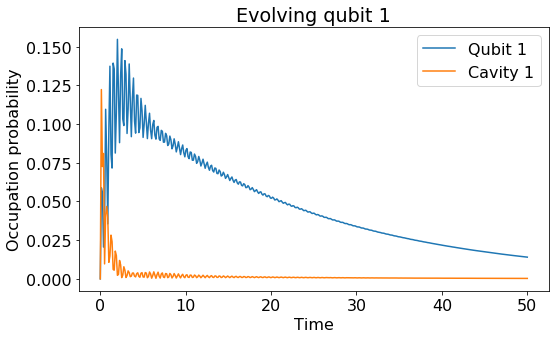

In [49]:
fig,ax = plt.subplots(figsize=(8,5), tight_layout=True)
ax.plot(result.times, result.expect[0], label="Qubit 1");
ax.plot(result.times, result.expect[2], label="Cavity 1");
ax.set_xlabel('Time');
ax.set_ylabel('Occupation probability');
ax.legend(loc=0)
ax.set_title('Evolving qubit 1')

Text(0.5, 1.0, 'Evolving qubit 1')

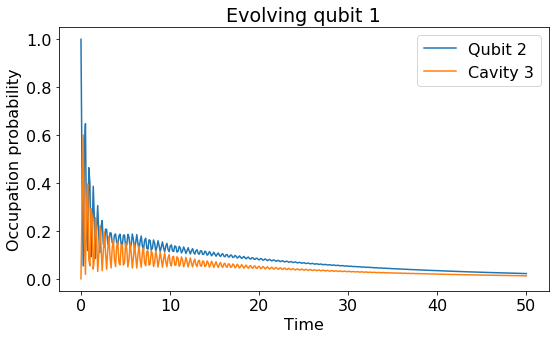

In [50]:
fig,ax = plt.subplots(figsize=(8,5), tight_layout=True)
ax.plot(result.times, result.expect[1], label="Qubit 2");
ax.plot(result.times, result.expect[4], label="Cavity 3");
ax.set_xlabel('Time');
ax.set_ylabel('Occupation probability');
ax.legend(loc=0)
ax.set_title('Evolving qubit 1')

Text(0.5, 1.0, 'Evolving qubit 1')

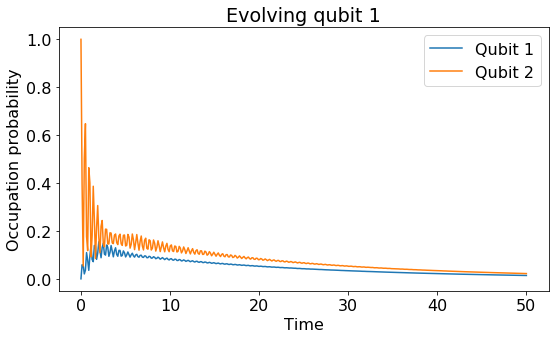

In [51]:
fig,ax = plt.subplots(figsize=(8,5), tight_layout=True)
ax.plot(result.times, result.expect[0], label="Qubit 1");
ax.plot(result.times, result.expect[1], label="Qubit 2");
ax.set_xlabel('Time');
ax.set_ylabel('Occupation probability');
ax.legend(loc=0)
ax.set_title('Evolving qubit 1')